In [1]:
from utils.splitters import k_fold_edge_split
from utils.dataset_loader import load_dataframes
from model import Net
from utils.util_functions import device_finder, plotter
from utils.util_functions import train_model_on_folds_and_decode_all, all_features_graph_data, save_preds_in_csv
from utils.util_functions import predict_all_top_edges, predict_top_new_edges, plot_comparison
from utils.util_functions import heatmap_comparion_visualization
import warnings
from utils.util_functions import decoding_drug_ids
from utils.graph_data_creater import create_graph_data_with_different_features
from sklearn.preprocessing import MinMaxScaler
import pathlib
import os
from torch_geometric.data import Data
import numpy as np
# plotting shapes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
# setting seeds
import torch
import random
from pathlib import Path

# Creating required folders

In [2]:
base_dir = str(pathlib.Path().resolve())

path_list = []

in_path = f'{base_dir}/results/predicted_values'
out_path = f'{base_dir}/results/scaled_predicted_values'
top_predicted_path = f'{base_dir}/results/top_drug_pairs'
unique_top_predicted_path = f'{base_dir}/results/unique_top_drug_pairs'
new_unique_top_predicted_path = f'{base_dir}/results/new_unique_top_drug_pairs'
final_unique_top_drug_pairs_path = f'{base_dir}/results/final_new_unique_top_drug_pairs'

path_list.append(in_path)
path_list.append(out_path)
path_list.append(top_predicted_path)
path_list.append(unique_top_predicted_path)
path_list.append(new_unique_top_predicted_path)
path_list.append(final_unique_top_drug_pairs_path)

for my_path in path_list:
    Path(my_path).mkdir(parents=True, exist_ok=True)

# Finding all the existing drug pairs

In [3]:
all_drugs_df = pd.read_csv('AllComb.csv')
all_d1_list = []
all_d2_list = []
all_drug_comb_list = []

for each in all_drugs_df.values:
    all_d1_list.append(each[0])
    all_d2_list.append(each[1])
    all_drug_comb_list.append(f'{each[0]}-{each[1]}')

# Normalizing the predictions (0-1 range)

In [5]:
data_list_names = ['drug_target', 'word2vec', 'node2vec', 'drug_finger', 'indication', 'side_effec', 'drug_finger_ecfp4', 'all_features']
model_list_names = ['GCN', 'SAGE', 'GAT', 'SAGE_GCN', 'GAT_SAGE', 'GCN_GAT']

for data_name in data_list_names:
    for model_name in model_list_names:
        for num in range(0, 5):
            name = f'{data_name}-{model_name}-{num}.csv'
            tmp_df = pd.read_csv(f'{in_path}/{name}')
            cols = list(tmp_df.columns)
            my_max = tmp_df.max().max()
            my_min = tmp_df.min().min()
            t = (tmp_df - my_min) / (my_max - my_min)
            t.to_csv(f'{out_path}/{name}', index=False)

In [6]:
result_df_list = []
drug_name_list = []

for data_name in data_list_names:
    for model_name in model_list_names:
        for num in range(0, 5):
            name = f'{data_name}-{model_name}-{num}.csv'
            tmp_df = pd.read_csv(f'{out_path}/{name}')
            cols = list(tmp_df.columns)  
            tmp_df.index = list(tmp_df.columns)
            result_df_list.append(tmp_df)
            drug_name_list.append(name)

# Finding drug pairs with top scores (higher than 0.5)

In [7]:
treshold = 0.5
for k, df in enumerate(result_df_list):
    score_list = []
    d1_list = []
    d2_list = []
    d_names = list(df.columns)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            score = df.iloc[i, j]
            if score > treshold:
                d1_list.append(d_names[i])
                d2_list.append(d_names[j])
                score_list.append(score)
    t_df = pd.DataFrame()
    t_df['d1'] = d1_list
    t_df['d2'] = d2_list
    t_df['score'] = score_list
    t_df.sort_values('score', ascending=False)
    t_df.to_csv(f'results/top_drug_pairs/{drug_name_list[k]}', index=False)

# Finding drug top unique drug pairs

In [3]:
data_list_names = ['drug_target', 'word2vec', 'node2vec', 'drug_finger', 'indication', 'side_effect', 'drug_finger_ecfp4', 'all_features']
data_list_names = ['drug_finger', 'indication', 'side_effec', 'drug_finger_ecfp4', 'all_features']
# data_list_names = ['indication', 'side_effec', 'drug_finger_ecfp4', 'all_features']
# data_list_names = ['drug_finger_ecfp4', 'all_features']
# data_list_names = ['drug_finger']
# model_list_names = ['GAT_SAGE', 'GCN_GAT']

for data_name in data_list_names:
    for model_name in model_list_names:
        drug_names_dict = dict()
        drug_scores_dict = dict()
        base_name = f'{data_name}-{model_name}.csv'
        print(base_name)
        for num in range(0, 5):
            name = f'{data_name}-{model_name}-{num}.csv'
            tmp_df = pd.read_csv(f'{top_predicted_path}/{name}')
            for row in tmp_df.values:
                d1 = str(row[0])
                d2 = str(row[1])
                score = float(row[2])
                comb =  f'{d1}-{d2}' 
                if comb in list(drug_names_dict.keys()):
                    drug_names_dict[comb] += 1
                    drug_scores_dict[comb] = drug_scores_dict[comb] + score
                else:
                    drug_names_dict[comb] = 1
                    drug_scores_dict[comb] = score
        d1_list = []
        d2_list = []
        score_list = []
        for key in list(drug_names_dict.keys()):
            if drug_names_dict[key] == 5:
                d1, d2 = key.split('-')
                score = drug_scores_dict[key]
                score = score / 5
                d1_list.append(d1)
                d2_list.append(d2)
                score_list.append(score)
        new_df = pd.DataFrame()
        new_df['d1'] = d1_list
        new_df['d2'] = d2_list
        new_df['score'] = score_list
        new_df.to_csv(f'{unique_top_predicted_path}/{base_name}', index=False)

drug_finger-GAT_SAGE.csv
drug_finger-GCN_GAT.csv


# Finding New top unique drug pairs

In [6]:
data_list_names = ['drug_target', 'word2vec', 'node2vec', 'drug_finger', 'indication', 'side_effec', 'drug_finger_ecfp4', 'all_features']
model_list_names = ['GCN', 'SAGE', 'GAT', 'SAGE_GCN', 'GAT_SAGE', 'GCN_GAT']

for data_name in data_list_names:
    for model_name in model_list_names:
        name = f'{data_name}-{model_name}.csv'
        tmp_df = pd.read_csv(f'{unique_top_predicted_path}/{name}')
        d1_list = []
        d2_list = []
        score_list = []
        for row in tmp_df.values:
            d1 = row[0]
            d2 = row[1]
            score = float(row[2])
            if f'{d1}-{d2}' in all_drug_comb_list or f'{d1}-{d2}' in all_drug_comb_list or d1 == d2:
                pass
            else:
                d1_list.append(d1)
                d2_list.append(d2)
                score_list.append(score)
        t = pd.DataFrame()
        t['d1'] = d1_list
        t['d2'] = d2_list
        t['score'] = score_list
        t.to_csv(f'{new_unique_top_predicted_path}/{name}')

# Showing the frequency of drug pairs with different tresholds 

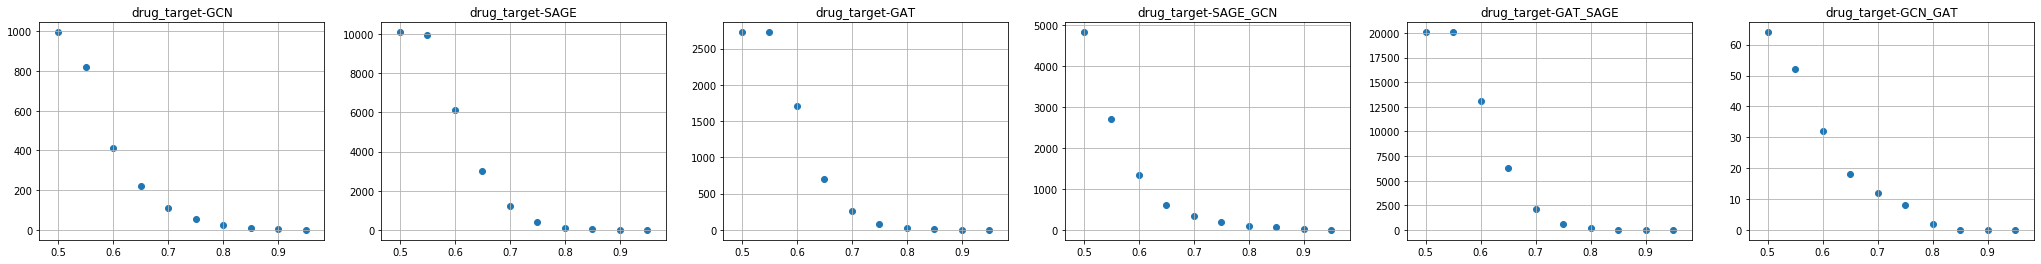

[1, 0, 0, 13, 2, 0]


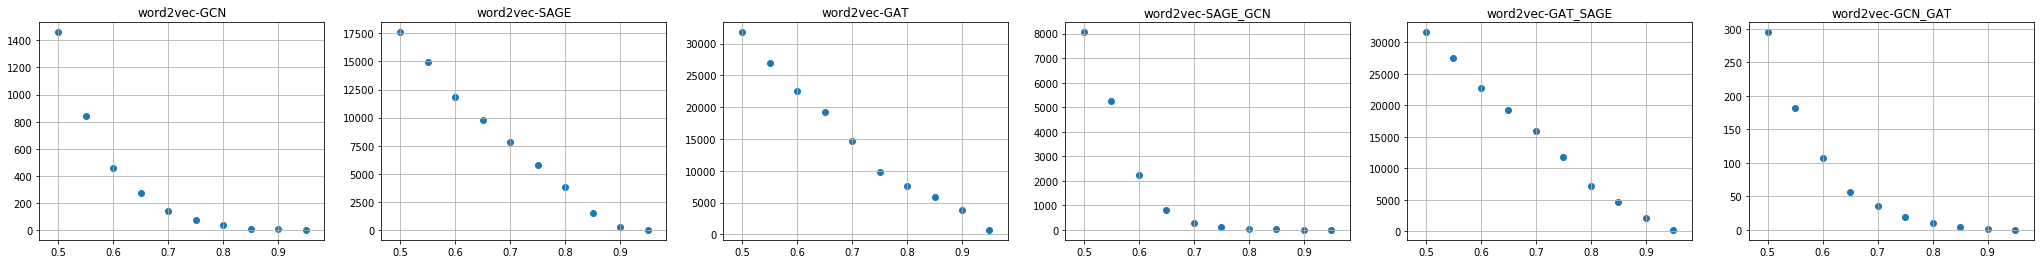

[1, 16, 693, 0, 202, 0]


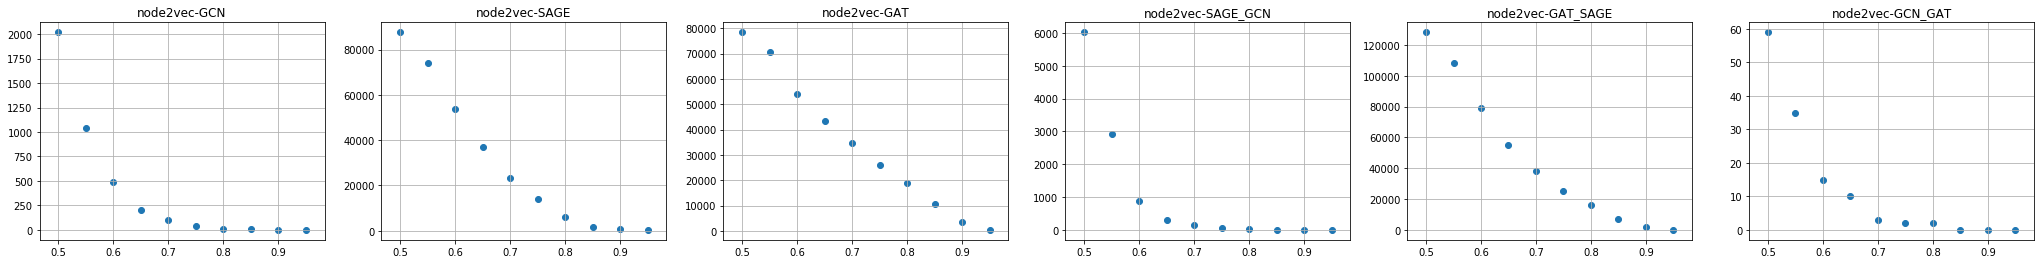

[0, 330, 373, 0, 45, 0]


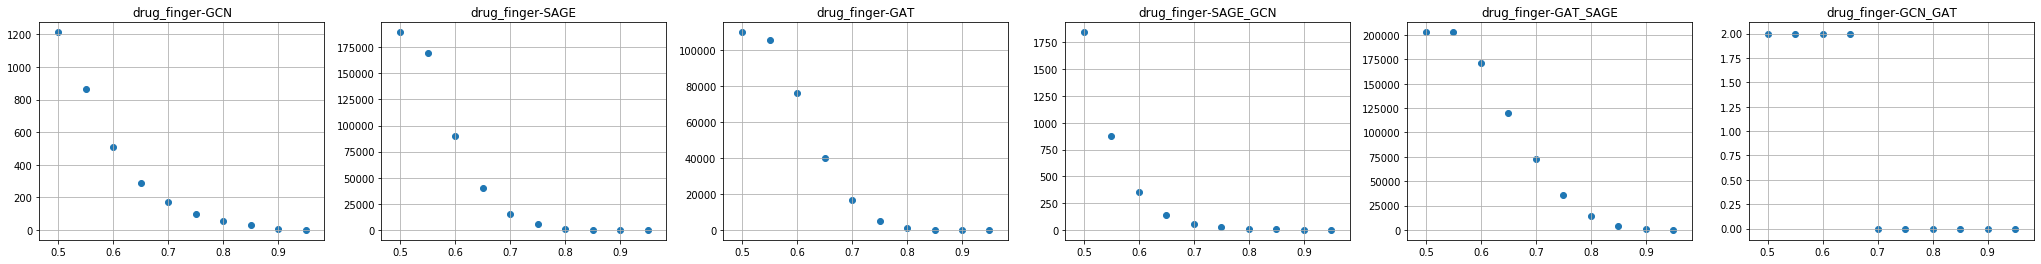

[1, 1, 2, 0, 67, 0]


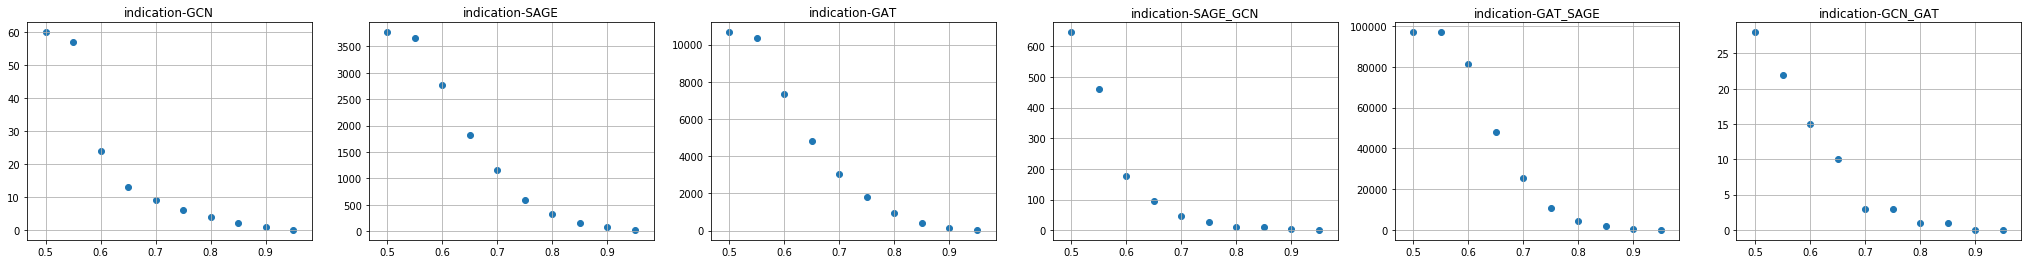

[0, 24, 32, 1, 66, 0]


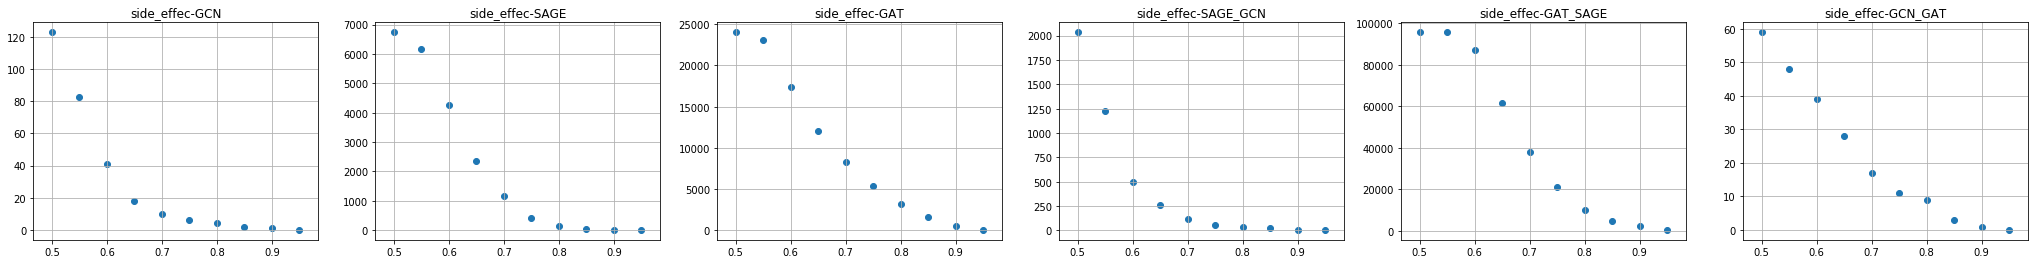

[0, 5, 56, 5, 448, 0]


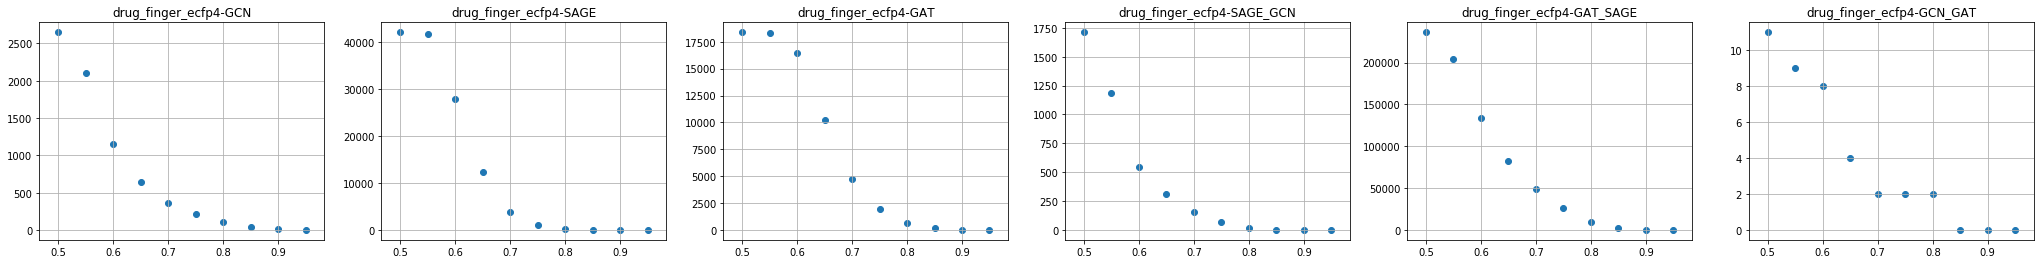

[4, 2, 0, 0, 31, 0]


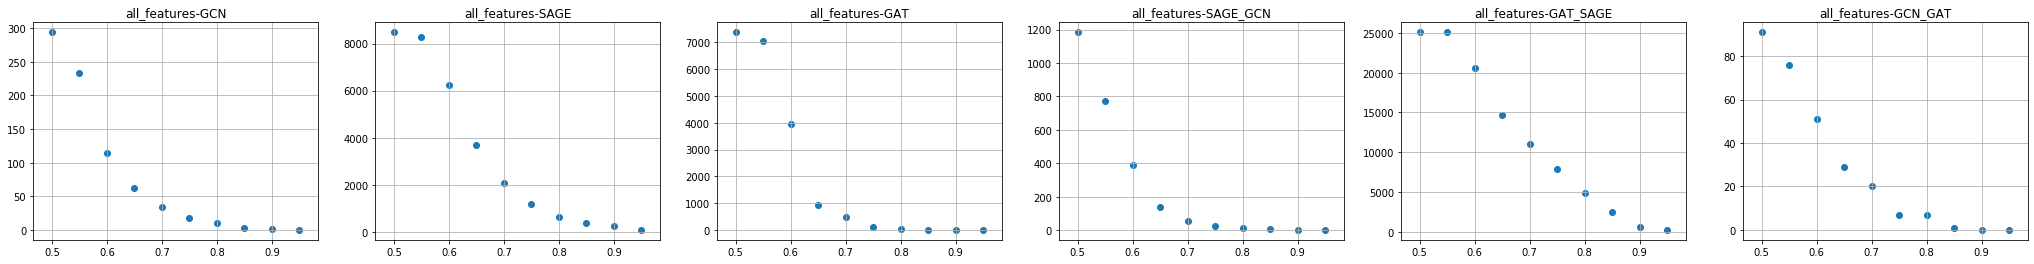

[0, 79, 0, 1, 226, 0]


In [55]:
data_list_names = ['drug_target', 'word2vec', 'node2vec', 'drug_finger', 'indication', 'side_effec', 'drug_finger_ecfp4', 'all_features']
model_list_names = ['GCN', 'SAGE', 'GAT', 'SAGE_GCN', 'GAT_SAGE', 'GCN_GAT']
treshold_list = [i * 0.05 for i in range(10, 20)]
all_range_list = []
all_last_list = []

for i, data_name in enumerate(data_list_names):
    plt.figure(figsize=(48, 4))
    tmp_last_list = []
    for j, model_name in enumerate(model_list_names):
        name = f'{data_name}-{model_name}'
        tmp_df = pd.read_csv(f'{new_unique_top_predicted_path}/{name}.csv')
        tmp_range_list = []
        for treshold in treshold_list:
            my_df = tmp_df[tmp_df['score'] >= treshold]
            pairs_num = my_df.shape[0]
            tmp_range_list.append(pairs_num)
            if treshold >= 0.95:
                tmp_last_list.append(pairs_num)
        all_range_list.append(tmp_range_list)
        plt.subplot(180 + j + 1)
        plt.scatter(treshold_list, tmp_range_list)
        plt.title(name)
        
        plt.grid(True)
    plt.show()
    all_last_list.append(tmp_last_list)
    print(tmp_last_list)

# Finding the final scores of output drug pairs in one unique file 
### (Score and the number of times found in diffenret models is acounted)

In [6]:
data_list_names = ['drug_target', 'word2vec', 'node2vec', 'drug_finger', 'indication', 'side_effec', 'drug_finger_ecfp4', 'all_features']
model_list_names = ['GCN', 'SAGE', 'GAT', 'SAGE_GCN', 'GAT_SAGE', 'GCN_GAT']

all_drug_pairs_dict = dict()
all_drug_pairs_count_dict = dict()

for i, data_name in enumerate(data_list_names):
    for j, model_name in enumerate(model_list_names):
        name = f'{data_name}-{model_name}'
        tmp_df = pd.read_csv(f'{new_unique_top_predicted_path}/{name}.csv')
        for row in tmp_df.values:
            d1 = row[1]
            d2 = row[2]
            score = row[3]
            if f'{d1}-{d2}' in list(all_drug_pairs_dict.keys()):
                all_drug_pairs_dict[f'{d1}-{d2}'] += score
                all_drug_pairs_count_dict[f'{d1}-{d2}'] += 1
            else:
                all_drug_pairs_dict[f'{d1}-{d2}'] = score
                all_drug_pairs_count_dict[f'{d1}-{d2}'] = 1

In [7]:
d1_list = []
d2_list = []
score_list = []
count_list = []

final_unique_top_drug_pairs_path = f'{base_dir}/results/final_new_unique_top_drug_pairs'

for key in list(all_drug_pairs_dict.keys()):
    score = all_drug_pairs_dict[key] / all_drug_pairs_count_dict[key]
    count_list.append(all_drug_pairs_count_dict[key])
    all_drug_pairs_dict[key] = score
    ds = key.split('-')
    d1 = ds[0]
    d2 = ds[1]
    d1_list.append(d1)
    d2_list.append(d2)
    score_list.append(score)

tmp_df = pd.DataFrame()
tmp_df['d1'] = d1_list
tmp_df['d2'] = d2_list
tmp_df['score'] = score_list
tmp_df['count'] = count_list

tmp_df.to_csv(f'{final_unique_top_drug_pairs_path}/main_results.csv', index=False)

In [4]:
df = pd.read_csv(f'{final_unique_top_drug_pairs_path}/main_results.csv')
print(df.shape)

(421383, 4)


In [14]:
tmppp

[421925, 393243, 272001, 131629, 49951, 17732, 5438, 1514, 657, 544]

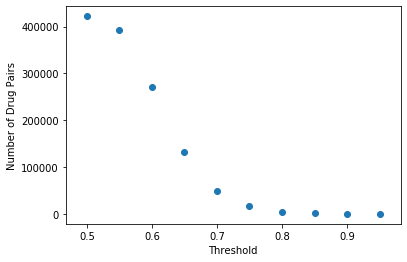

[0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001]
[421383, 392701, 271459, 131087, 49409, 17190, 4896, 972, 115, 2]


In [17]:
# treshold_list = [i * 0.05 for i in range(10, 20)]
# tmp_last_list = []

# for treshold in treshold_list:
#     my_df = df[df['score'] >= treshold]
#     pairs_num = my_df.shape[0]
#     tmp_last_list.append(pairs_num)

plt.scatter(treshold_list, tmppp)
plt.xlabel('Threshold')
plt.ylabel('Number of Drug Pairs')
plt.show()
print(treshold_list)
print(tmp_last_list)

In [15]:
tmppp = [each + 642 for each in tmp_last_list]

In [28]:
print("Thresholds    : [0.50,   0.55,   0.60,   0.65,   0.70,  0.75,  0.80, 0.85, 0.90, 0.95]")
print('No. Drug Pairs:', tmppp)

Thresholds    : [0.50,   0.55,   0.60,   0.65,   0.70,  0.75,  0.80, 0.85, 0.90, 0.95]
No. Drug Pairs: [422025, 393343, 272101, 131729, 50051, 17832, 5538, 1614, 757, 644]


In [49]:
df.sort_values('count', ascending=False)

,d1,d2,score,count
380,DCC0259,DCC0123,0.806086,42
382,DCC0259,DCC0156,0.774839,41
19,DCC0191,DCC0123,0.762004,41
548,DCC0156,DCC0123,0.808055,41
20,DCC0191,DCC0156,0.726508,41
...,...,...,...,...
246107,DCC0031,DCC1241,0.623930,1
246108,DCC0031,DCC1258,0.580688,1
246111,DCC0031,DCC1819,0.600853,1
246113,DCC0031,DCC1579,0.572733,1


In [62]:
df = pd.read_csv(f'{final_unique_top_drug_pairs_path}/main_results.csv')
print(df.shape)

(421383, 4)


In [63]:
# df = df[df['score']>= 0.8].to_csv('temp.csv', index=False)
df = df[df['score']>= 0.85]
df = df[df['count'] >= 2]
df.sort_values('score', ascending=False)

,d1,d2,score,count
100385,DCC1024,DCC0360,0.934618,3
85935,DCC0360,DCC1024,0.934618,3
57476,DCC0457,DCC1024,0.932513,3
100359,DCC1024,DCC0457,0.932513,3
85793,DCC0360,DCC0457,0.927215,3
...,...,...,...,...
53419,DCC0153,DCC0439,0.850299,3
96506,DCC1017,DCC0457,0.850218,3
57458,DCC0457,DCC1017,0.850218,3
101010,DCC0630,DCC0457,0.850143,3


In [64]:
d1_list = []
d2_list = []
score_list = []
count_list = []
drug_comb_list = []

for row in df.values:
    d1 = row[0]
    d2 = row[1]
    temp = f'{d1}-{d2}'
    rev_temp = f'{d2}-{d1}'

    if temp in drug_comb_list or rev_temp in drug_comb_list:
        continue
    else:
        pass
    drug_comb_list.append(temp)
    d1_list.append(d1)
    d2_list.append(d2)
    score = row[2]
    count = row[3]
    score_list.append(score)
    count_list.append(count)

df = pd.DataFrame()
df['d1'] = d1_list
df['d2'] = d2_list
df['score'] = score_list
df['count'] = count_list

In [65]:
ds_name = pd.read_csv(f'{base_dir}/datasets/drug_atc.csv')

In [66]:
drug_name_dict = dict()
drug_atc_dict = dict()

for row in ds_name.values:
    drug = row[0]
    name = row[1]
    atc = row[2]
    drug_name_dict[drug] = name
    drug_atc_dict[drug] = atc

In [67]:
d1_list = []
d2_list = []
atc1_list = []
atc2_list = []
atc1_first_list = []
atc2_first_list = []

for row in df.values:
    d1_list.append(drug_name_dict[row[0]])
    d2_list.append(drug_name_dict[row[1]])
    atc1 = drug_atc_dict[row[0]]
    atc2 = drug_atc_dict[row[1]]
    atc1_list.append(atc1)
    atc2_list.append(atc2)
    atc1_first_list.append(atc1[0])
    atc2_first_list.append(atc2[0])
    

df['n1'] = d1_list
df['n2'] = d2_list
df['atc1'] = atc1_list
df['atc2'] = atc2_list
df['atc1_first'] = atc1_first_list
df['atc2_first'] = atc2_first_list

In [74]:
df

,d1,d2,score,count,n1,n2,atc1,atc2,atc1_first,atc2_first
0,DCC1555,DCC1639,0.858959,8,Panitumumab,Ixabepilone,L01XC08,L01DC04,L,L
1,DCC1555,DCC1688,0.861145,8,Panitumumab,Axitinib,L01XC08,L01XE17,L,L
2,DCC0189,DCC1024,0.856903,4,Irinotecan,Teprotumumab,L01XX19,-,L,-
3,DCC0120,DCC1024,0.851473,4,Oxaliplatin,Teprotumumab,L01XA03,-,L,-
4,DCC0307,DCC1024,0.855440,4,Trimetrexate,Teprotumumab,P01AX07,-,P,-
...,...,...,...,...,...,...,...,...,...,...
425,DCC1688,DCC0532,0.855031,3,Axitinib,Trientine,L01XE17,-,L,-
426,DCC1624,DCC0403,0.884125,3,Uracil,Tegafur,-,L01BC03,-,L
427,DCC1624,DCC0532,0.850884,3,Uracil,Trientine,-,-,-,-
428,DCC1624,DCC0956,0.851078,3,Uracil,Obatoclax,-,-,-,-


In [75]:
# df[df['score'] >= 0.9]
# df.iloc['n1', '4-dihydroxypyrimidine"']
for row in df.values:
    if row[4] == '4-dihydroxypyrimidine"':
        print(row)

In [59]:
df.to_csv('results_85_2.csv', index=False)

In [3]:
torch.__version__

'1.11.0+cu102'

In [4]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

In [6]:
np.__version__

'1.18.1'

In [7]:
pd.__version__

'1.0.1'